In [1]:
import numpy as np
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance
from gudhi.wasserstein.barycenter import lagrangian_barycenter
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

### Data Clouds

In [2]:
def create_circle(radius, num_points):
    angles = np.linspace(0, 2 * np.pi, num_points)
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    return np.vstack((x, y)).T

def create_grid(num_points):
    side_points = int(np.sqrt(num_points))
    x = np.linspace(-1, 1, side_points)
    y = np.linspace(-1, 1, side_points)
    xx, yy = np.meshgrid(x, y)
    return np.vstack((xx.ravel(), yy.ravel())).T

def create_two_circles(radius, num_points, distance):
    angles = np.linspace(0, 2 * np.pi, num_points // 2)
    x1 = radius * np.cos(angles) - distance / 2
    y1 = radius * np.sin(angles)
    x2 = radius * np.cos(angles) + distance / 2
    y2 = radius * np.sin(angles)
    x = np.concatenate((x1, x2))
    y = np.concatenate((y1, y2))
    return np.vstack((x, y)).T

def create_empty_diamond(num_points):
    side_points = num_points // 4
    x1 = np.linspace(-1, 0, side_points)
    y1 = np.linspace(0, 1, side_points)
    x2 = np.linspace(0, 1, side_points)
    y2 = np.linspace(1, 0, side_points)
    x3 = np.linspace(1, 0, side_points)
    y3 = np.linspace(0, -1, side_points)
    x4 = np.linspace(0, -1, side_points)
    y4 = np.linspace(-1, 0, side_points)
    x = np.concatenate((x1, x2, x3, x4))
    y = np.concatenate((y1, y2, y3, y4))
    return np.vstack((x, y)).T


def create_noise_point(num_points):
    x = np.random.normal(0, 1, num_points)
    y = np.random.normal(0, 1, num_points)
    return np.vstack((x, y)).T

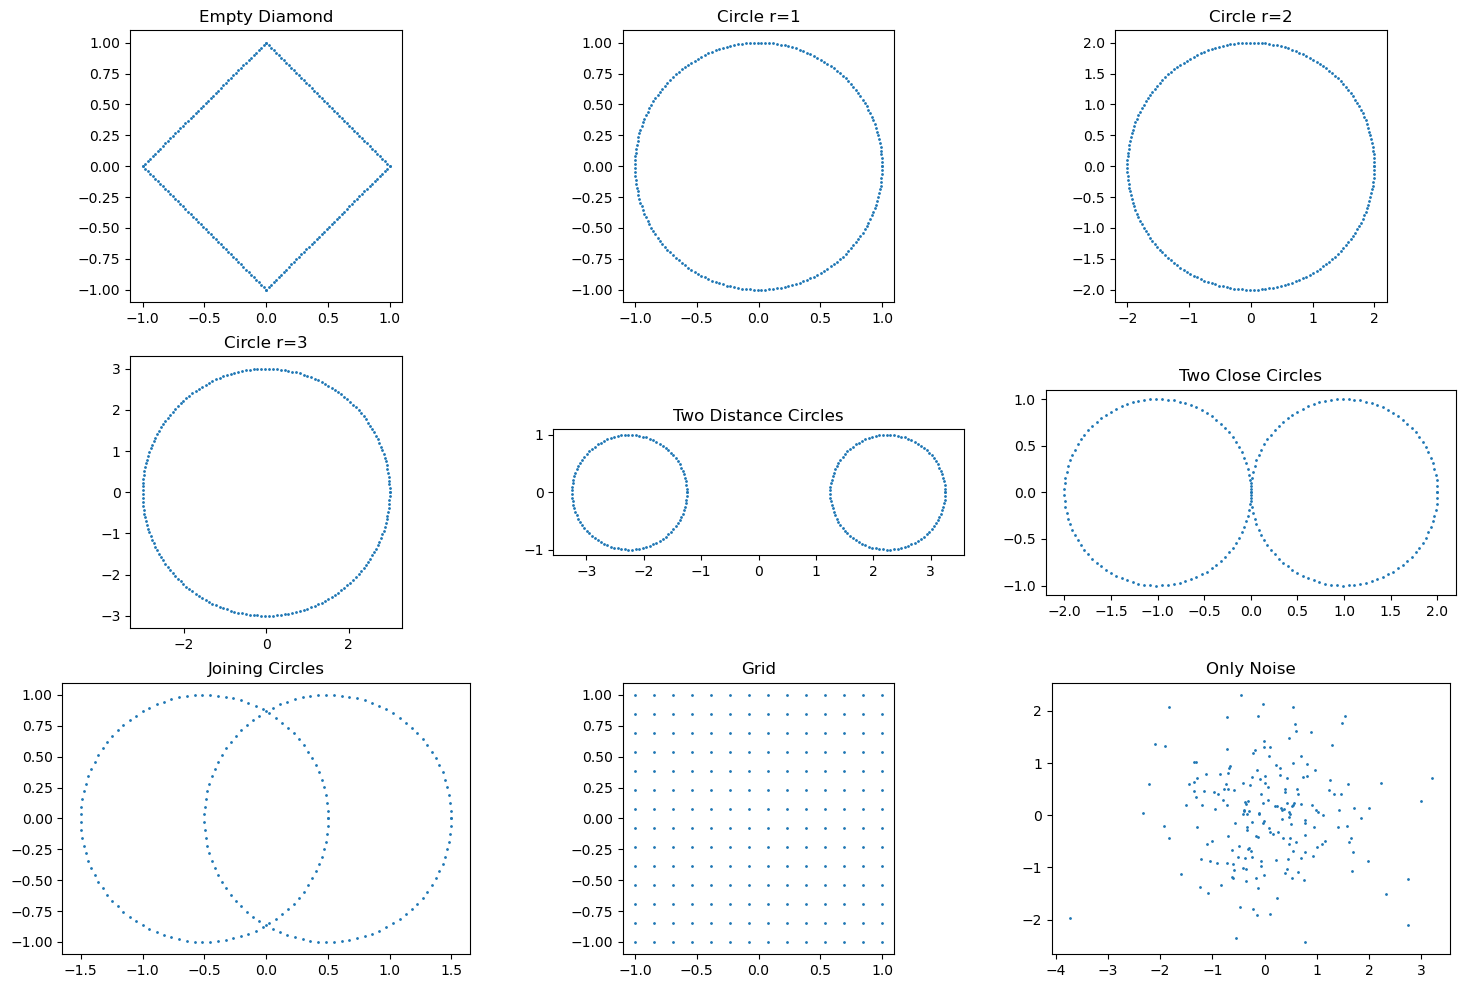

In [3]:
# Parameters
radius = 1
num_points = 200

point_clouds={
    "Empty Diamond":create_empty_diamond(num_points),
    "Circle r=1":create_circle(radius, num_points),
    "Circle r=2":create_circle(2, num_points),
    "Circle r=3":create_circle(3, num_points),
    "Two Distance Circles":create_two_circles(radius, num_points, 4.5),
    "Two Close Circles":create_two_circles(radius, num_points, 2),
    "Joining Circles":create_two_circles(radius, num_points, 1),
    "Grid":create_grid(num_points),
    "Only Noise":create_noise_point(num_points)
}


# Plotting
plt.figure(figsize=(18, 12))
i=1
for name,pc in point_clouds.items():
    plt.subplot(3,3,i)
    i+=1
    plt.scatter(pc[:, 0], pc[:, 1], s=1)
    plt.title(name)
    plt.gca().set_aspect("equal")


plt.show()

### Persistent Homology

In [4]:
### This function is from Giotto Library
def _ideal_thresh(dm, thresh):
    """Compute the enclosing radius of an input distance matrix.

    Under a Vietoris–Rips filtration, all homology groups are trivial above
    this value because the complex becomes a cone.

    The enclosing radius is only computed if the input matrix is square."""

    # Check that matrix is square
    if dm.shape[0] != dm.shape[1]:
        return thresh

    # Compute enclosing radius
    enclosing_radius = np.min(np.max(dm, axis=1))

    return min([enclosing_radius, thresh])

c:\Users\ragna\anaconda3\Lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


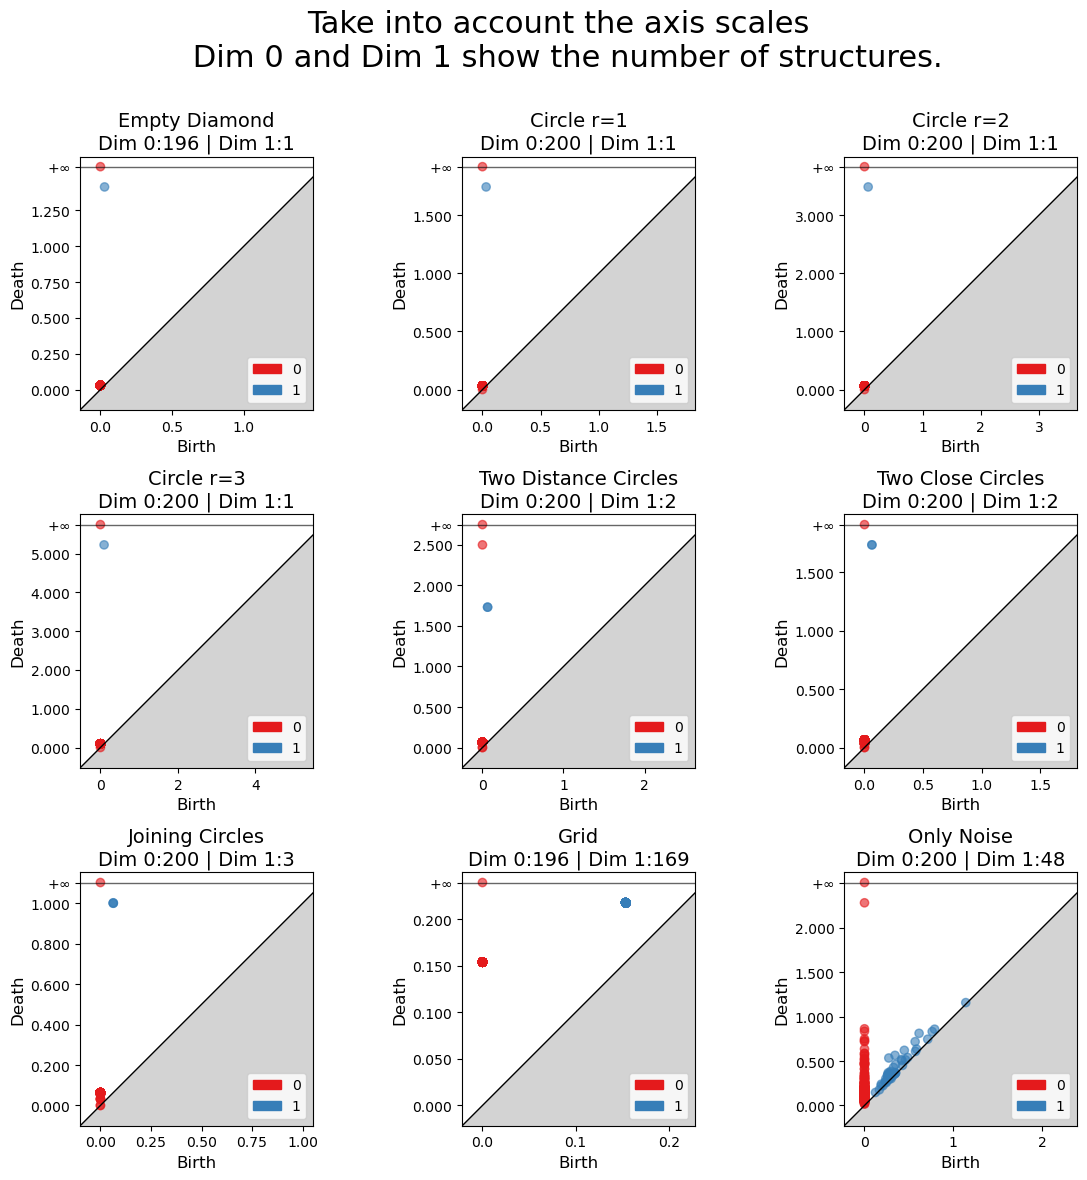

In [5]:
plt.figure(figsize=(12, 12))
i=1
barcodesDict={}
for name,pc in point_clouds.items():
    plt.subplot(3,3,i)
    i+=1
    
    max_thresh = _ideal_thresh(distance_matrix(pc, pc), np.inf)
    skeleton = gd.RipsComplex(points=pc, max_edge_length=max_thresh)
    simplex_tree = skeleton.create_simplex_tree(max_dimension=2)
    barcode = simplex_tree.persistence()
    
    diag_0 = simplex_tree.persistence_intervals_in_dimension(0)
    diag_1 = simplex_tree.persistence_intervals_in_dimension(1)
    barcodesDict[name]=(diag_0,diag_1)

    ax=plt.gca()
    gd.plot_persistence_diagram(barcode,axes=ax)
    plt.title(name+"\n"+"Dim 0:"+str(len(diag_0))+" | Dim 1:"+str(len(diag_1)),fontsize=14)
    plt.tight_layout()
    ax.set_aspect("equal")
    plt.xlabel('Birth', fontsize=12)
    plt.ylabel('Death', fontsize=12)

plt.suptitle("Take into account the axis scales \n Dim 0 and Dim 1 show the number of structures.\n",fontsize=22)
plt.tight_layout()
plt.show()


#### Wasserstein Distance Matrix
https://gudhi.inria.fr/python/latest/wasserstein_distance_user.html#

In [6]:
def wassersteinDistanceMatrix(barcode,dim,order):
    distanceMatrix={}
    for name1,_ in barcode.items():
        distanceMatrix[name1]={}
        for name2,_ in barcode.items():
            distanceMatrix[name1][name2]=round(wasserstein_distance(barcode[name1][dim],barcode[name2][dim],order=order),5)
    return pd.DataFrame(distanceMatrix)

def dendrogramFromDM(df):
    # Convert the distance matrix to condensed form
    #https://stackoverflow.com/questions/13079563/how-does-condensed-distance-matrix-work-pdist
    #https://stackoverflow.com/questions/41416498/dendrogram-or-other-plot-from-distance-matrix
    condensed_distance_matrix = squareform(df)

    # Compute the linkage matrix
    linkage_matrix = linkage(condensed_distance_matrix, method='ward',)

    # Dendogram
    dendo = dendrogram(
        linkage_matrix,
        labels=df.columns,    
        leaf_rotation=90)

    return dendo

def plotHeatmapsAndDendrogram(df_0,df_1,title):
    plt.figure(figsize=(12,10),dpi=250)

    # Plot the Heatmaps
    plt.subplot(2,2,1)
    sns.heatmap(df_0,cmap="viridis",linecolor="white",linewidths=1,fmt='.1f',annot=True)
    plt.title("Dim 0")

    plt.subplot(2,2,2)
    sns.heatmap(df_1,cmap="viridis",linecolor="white",linewidths=1,fmt='.1f',annot=True)
    plt.title("Dim 1")

    # Plot the Dendrograms
    plt.subplot(2,2,3)
    dendrogramFromDM(df_0)
    plt.title('Dim 0')
    plt.ylabel('Distance')

    plt.subplot(2,2,4)
    dendrogramFromDM(df_1)
    plt.title('Dim 1')
    plt.ylabel('Distance')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

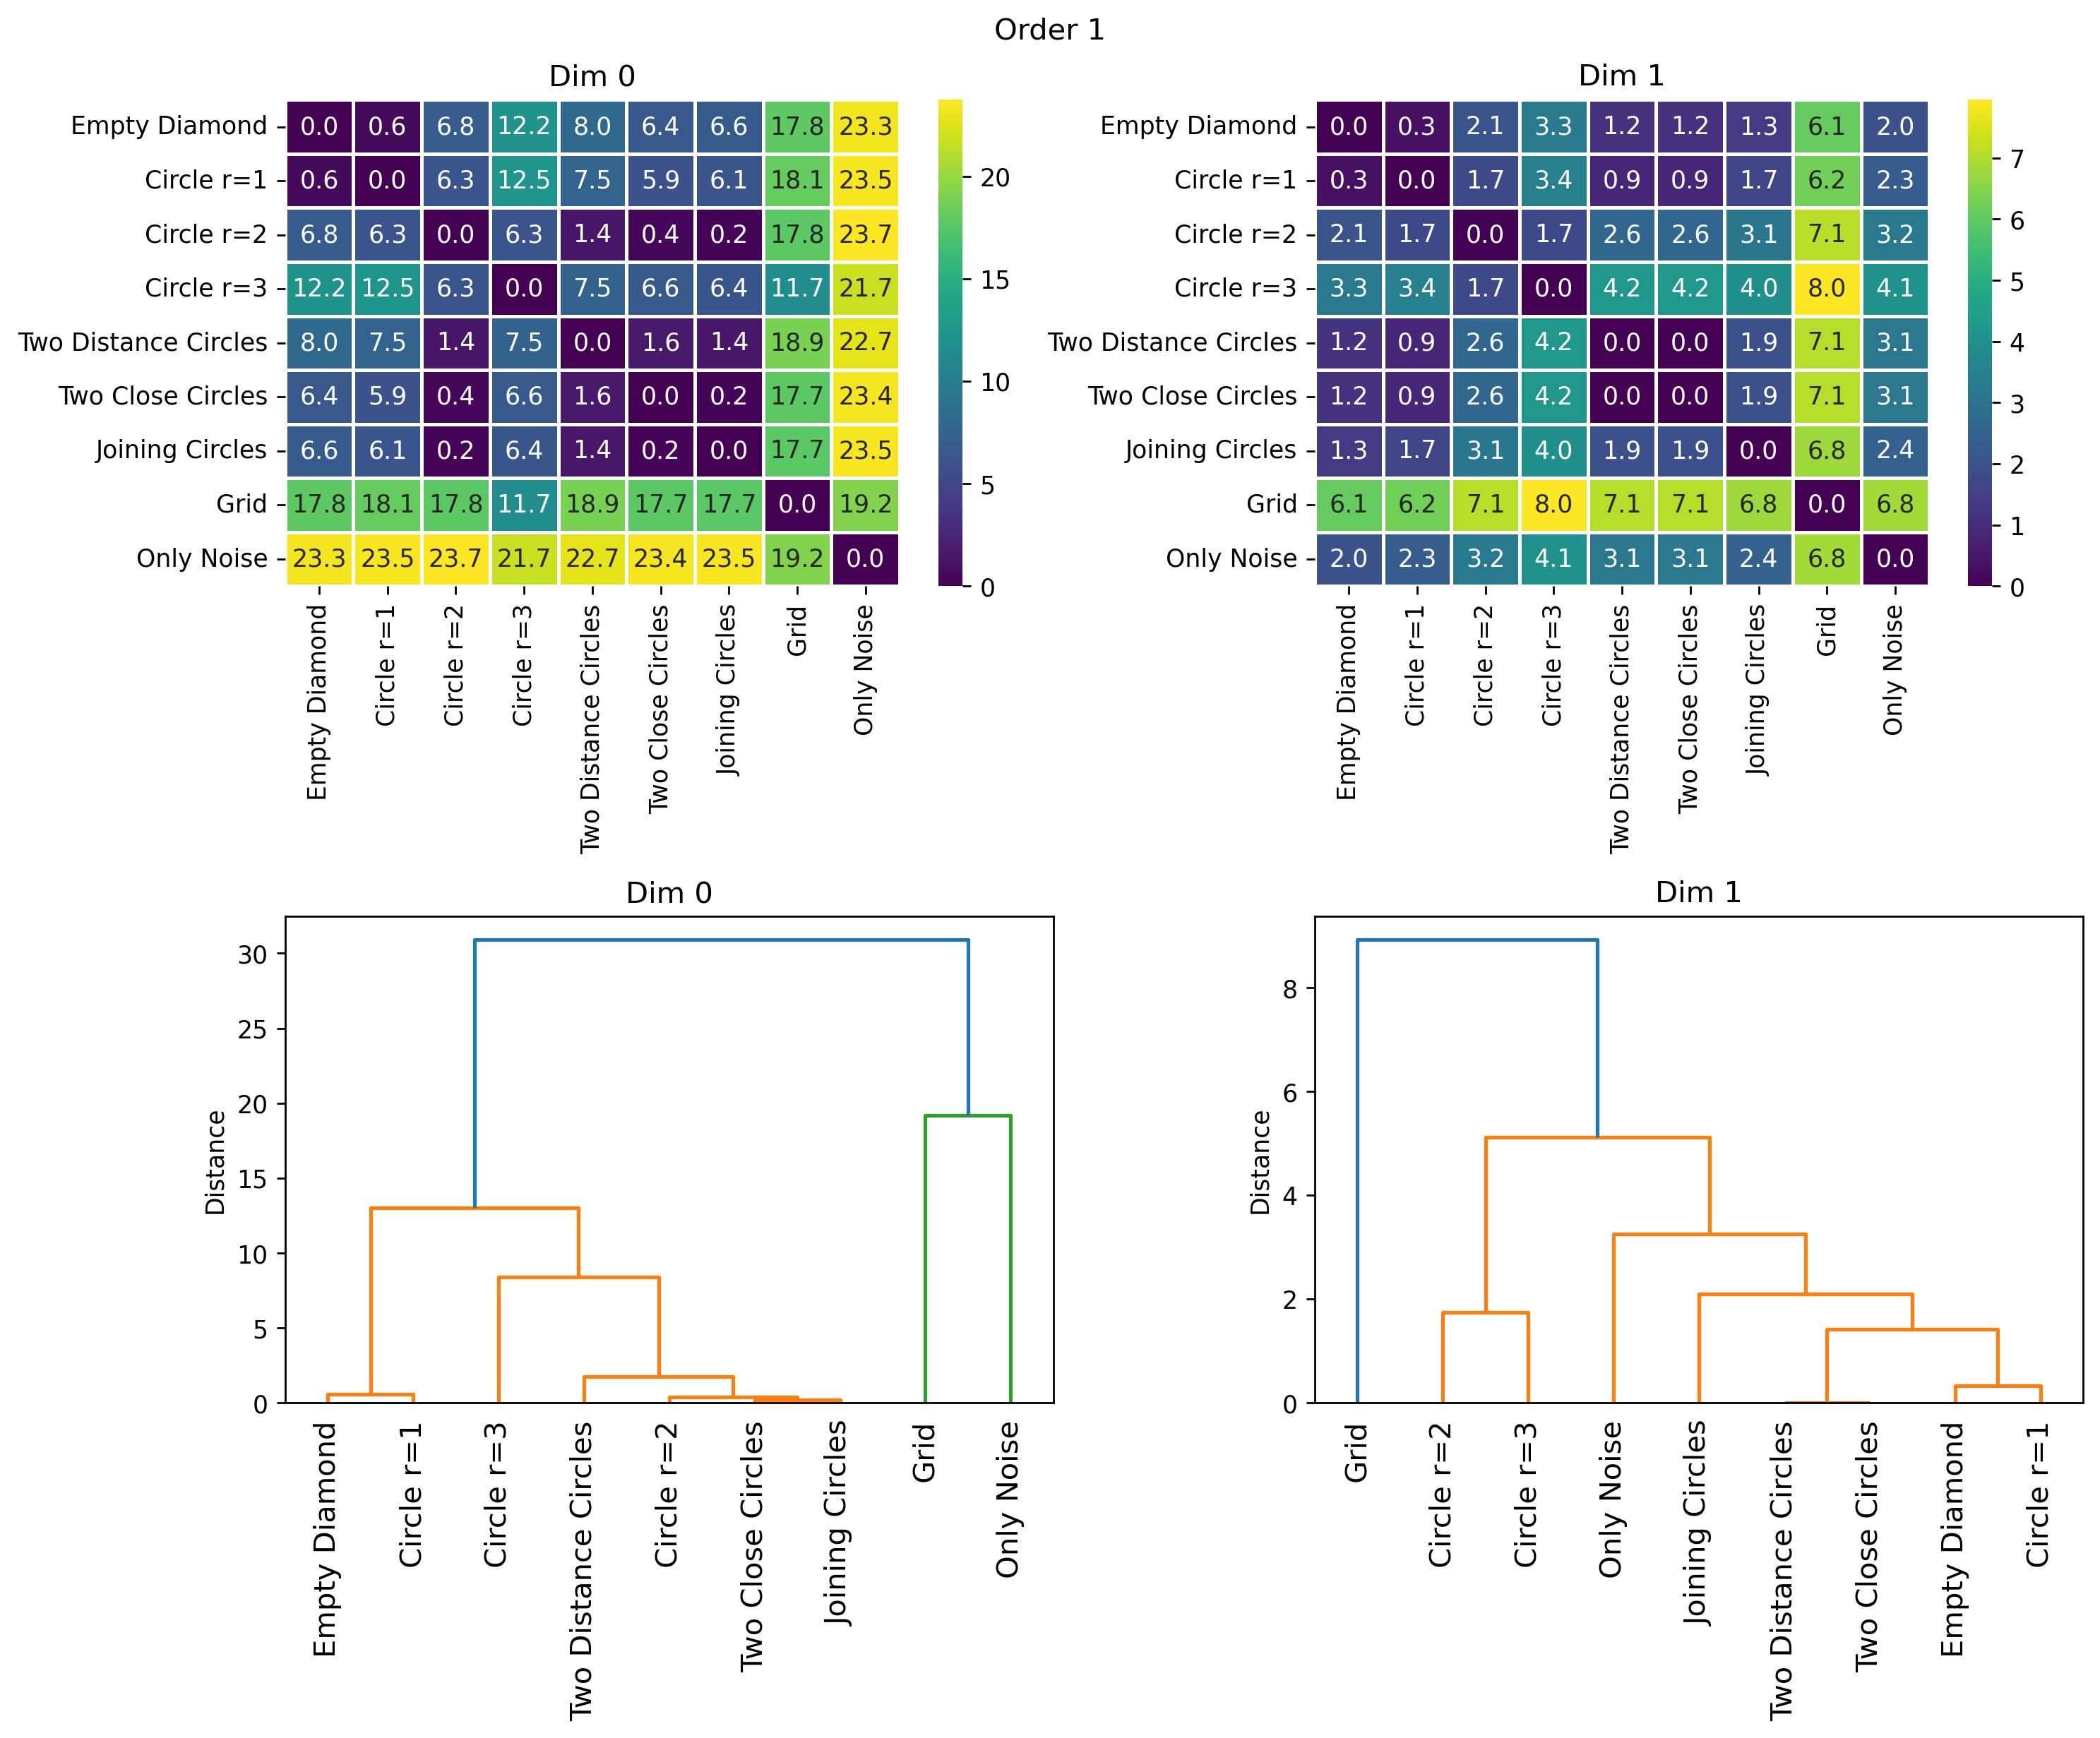

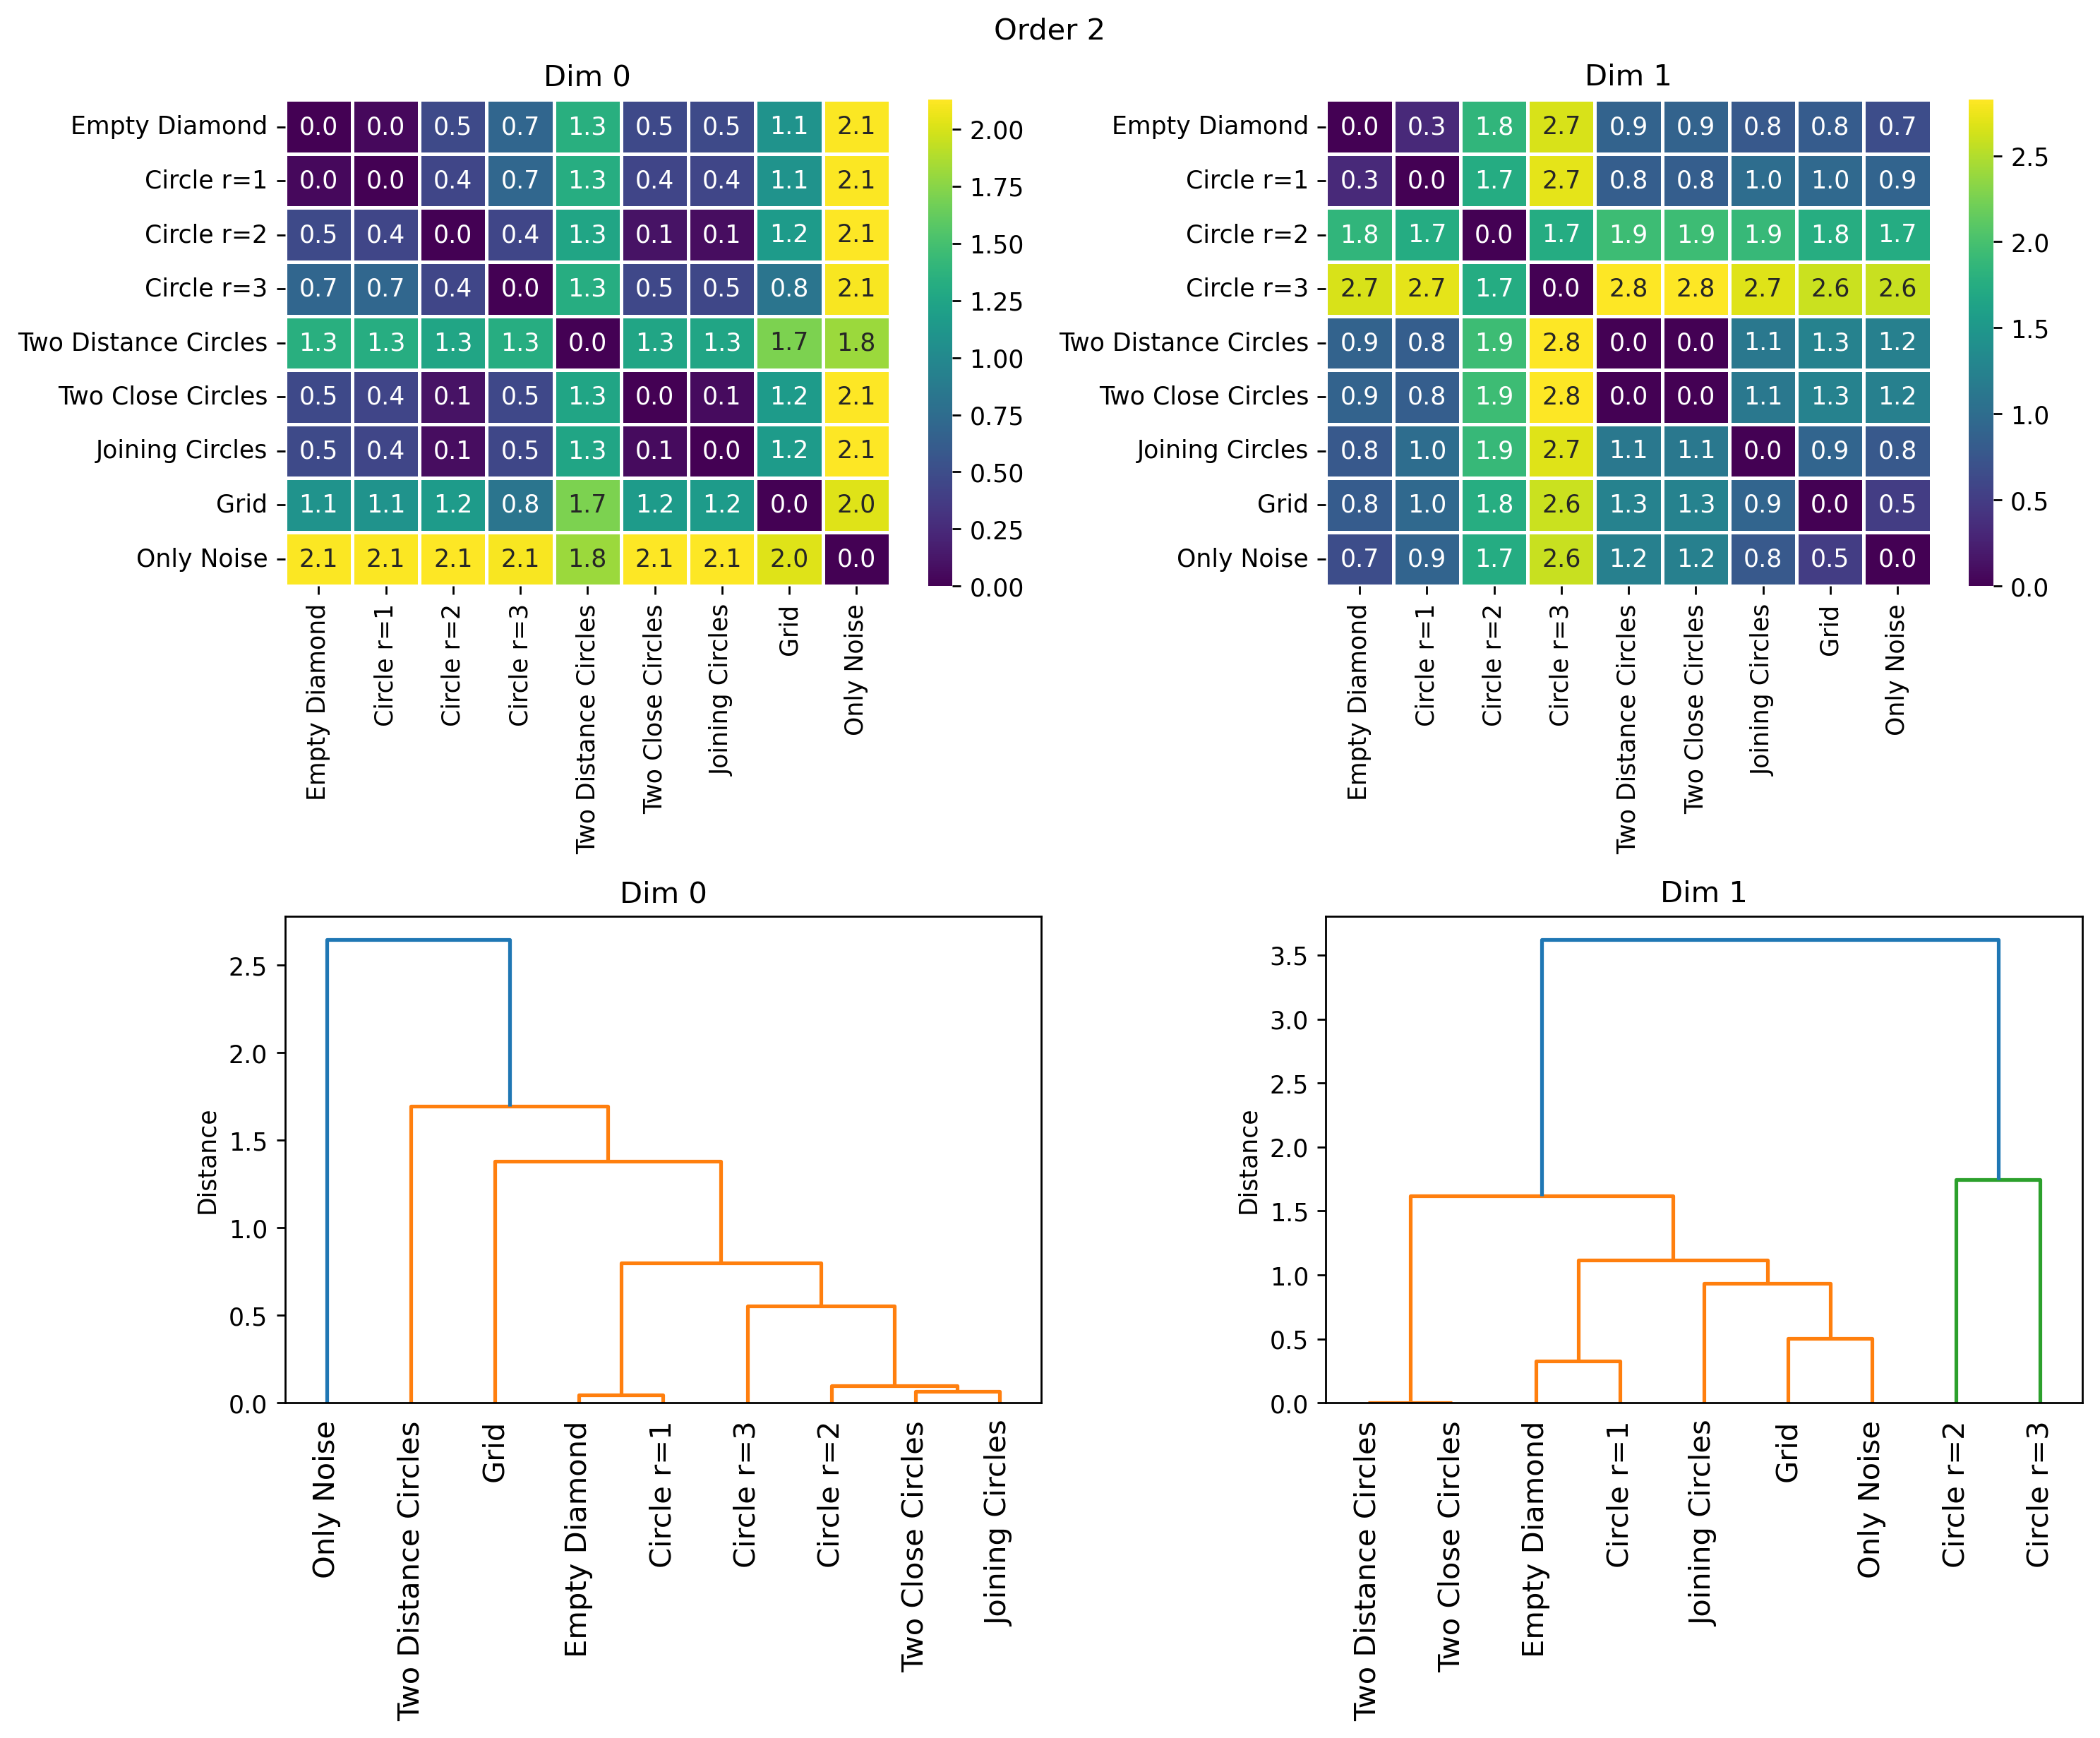

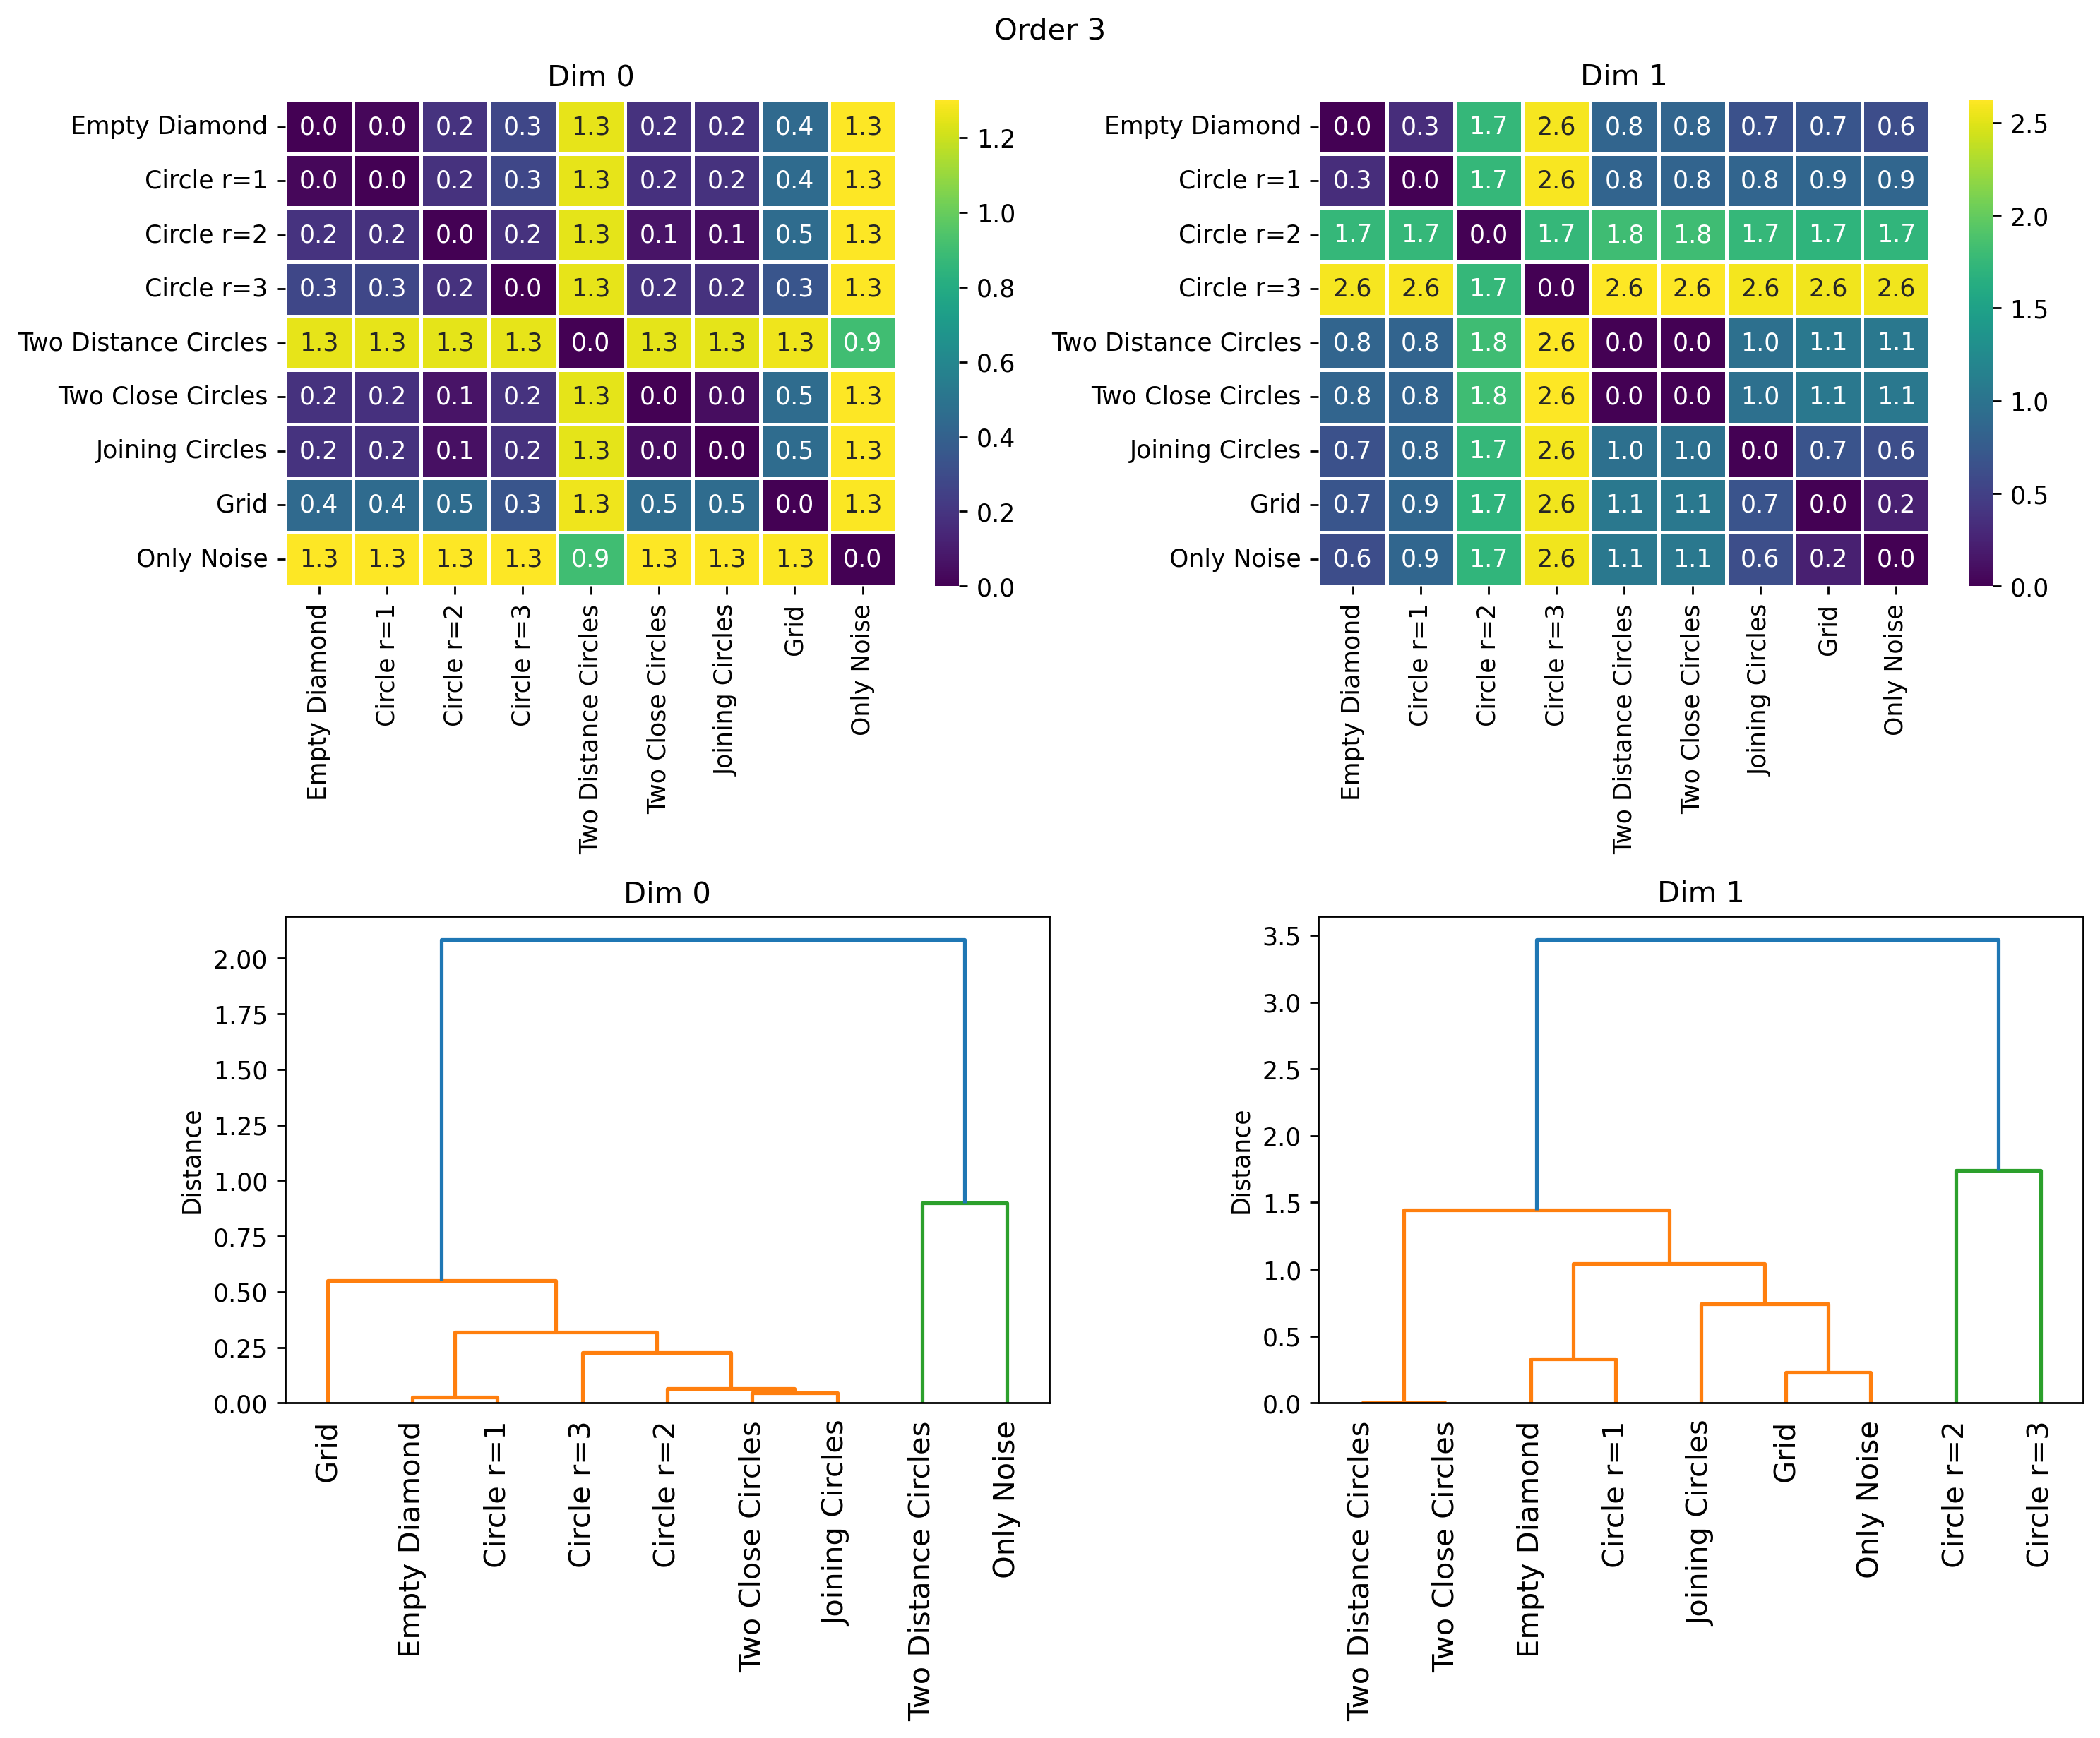

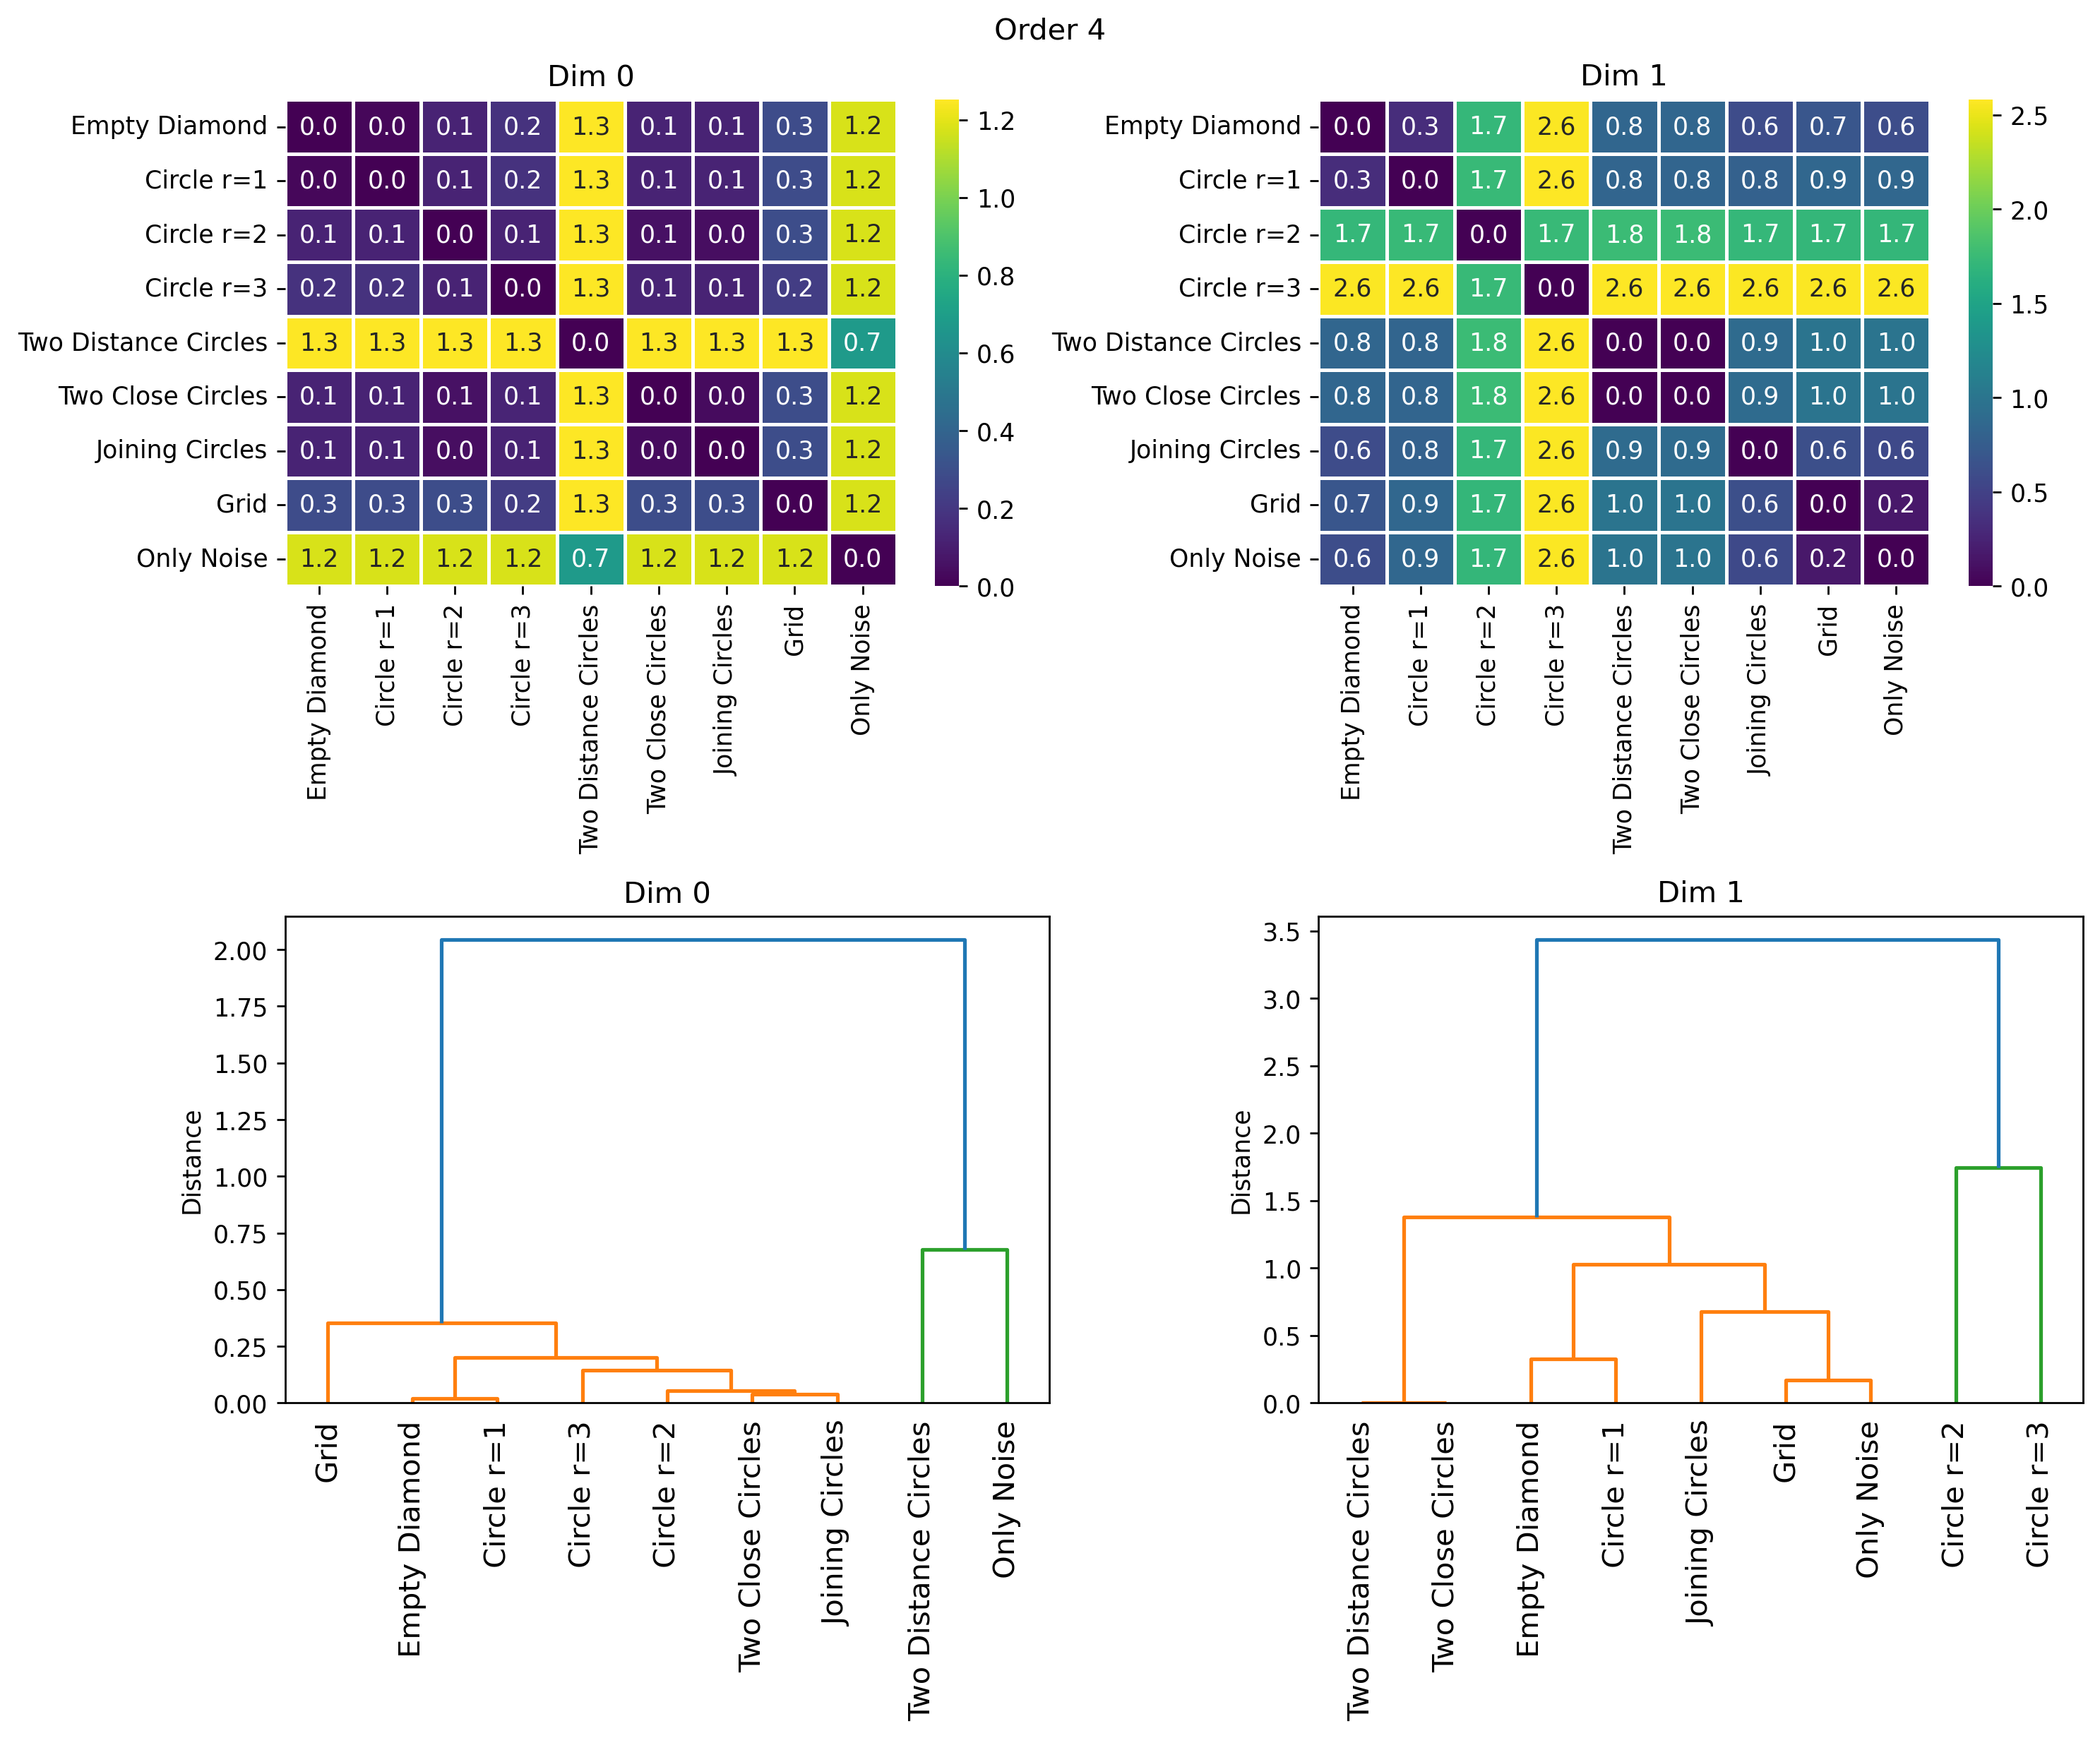

In [7]:
#Testing diferent Orders
distanceMatrixDim0_df=wassersteinDistanceMatrix(barcodesDict,0,1)
distanceMatrixDim1_df=wassersteinDistanceMatrix(barcodesDict,1,1)
plotHeatmapsAndDendrogram(distanceMatrixDim0_df,distanceMatrixDim1_df,"Order 1")


distanceMatrixDim0_df=wassersteinDistanceMatrix(barcodesDict,0,2)
distanceMatrixDim1_df=wassersteinDistanceMatrix(barcodesDict,1,2)
plotHeatmapsAndDendrogram(distanceMatrixDim0_df,distanceMatrixDim1_df,"Order 2")

distanceMatrixDim0_df=wassersteinDistanceMatrix(barcodesDict,0,3)
distanceMatrixDim1_df=wassersteinDistanceMatrix(barcodesDict,1,3)
plotHeatmapsAndDendrogram(distanceMatrixDim0_df,distanceMatrixDim1_df,"Order 3")

distanceMatrixDim0_df=wassersteinDistanceMatrix(barcodesDict,0,4)
distanceMatrixDim1_df=wassersteinDistanceMatrix(barcodesDict,1,4)
plotHeatmapsAndDendrogram(distanceMatrixDim0_df,distanceMatrixDim1_df,"Order 4")